## Softmax Regression Model

이번 실습의 목표는 다음과 같습니다.
1. 각각의 example들이 별도의 파일들로 존재하고, 각각의 example에 대한 label이 csv파일로 주어진 경우 이를 활용하여 데이터를 불러오는 과정을 익히기
2. a single layer linear neural network, cross-entropy loss function, stochastic gradient descent를 pytorch에서 제공하는 함수들을 이용하여 간편하게 구현하기
3. 미리 설정한 mini batch size 단위로 데이터를 가져오는 data loader를 구현하고, 이를 활용하여 model을 학습시켜보기
4. 학습과정에서 loss function의 값과 classification accuracy를 출력하기


In [3]:
import torch
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
import scipy.io as sio
import os
from torch import nn

### 데이터 불러오기
- 활용할 ecg데이터에 대한 정보가 정리되어 있는 csv파일을 불러 옵니다.

In [5]:
dpath = 'training2017'
d = pd.read_csv(os.path.join(dpath,'REFERENCE.csv'),header=None)
d[:3]

,0,1
0,A00001,N
1,A00002,N
2,A00003,N


- 불러온 테이블로부터 label인 Normal(N)인 파일들의 목록과 Atrial Fibrilation (A)인 파일들의 목록을 생성하고, 각각에 해당하는 파일의 개수를 확인합니다.

In [6]:
Nlist = d[d[1]=='N']
Alist = d[d[1]=='A']
print(len(Nlist),len(Alist))

5050 738


- Validation을 위한 데이터를 일부 분리하여 별도의 목록을 생성합니다.

In [7]:
Nvd = 50
Nlist_vd = Nlist[-Nvd:]
Alist_vd = Alist[-Nvd:]
Nlist = Nlist[:-Nvd]
Alist = Alist[:-Nvd]

- 생성한 목록을 이용하여 .mat확장자를 가지고 있는 데이터를 scipy의 함수를 이용하여 가져옵니다.
- 1800개의 샘플(300Hz로 샘플링된 데이터로 6초 구간에 해당)을 가져와서 시각화해봅니다.
- 각각의 데이터는 총 샘플의 개수가 다름에 유의하여야 합니다.
- 랜덤한 숫자를 생성하여 전체 샘플로부터 1800개의 샘플구간을 랜덤하게 가져올 수 있습니다.


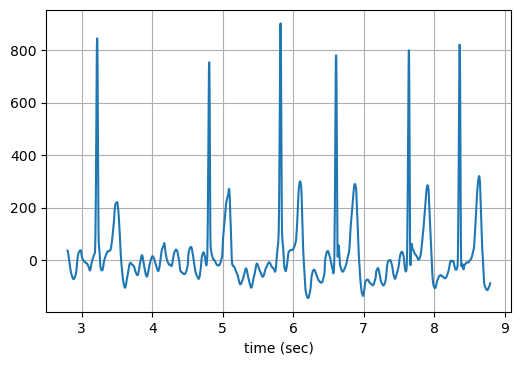

In [8]:
n= 150
sig = sio.loadmat(os.path.join(dpath,Alist.iloc[n,0]+'.mat'))
sig = sig['val']
t = np.arange(0,sig.shape[-1])/300
r1 = random.randint(500,1000)
plt.figure(dpi=100)
plt.plot(t[r1:r1+1800],sig[0,r1:r1+1800])
plt.xlabel('time (sec)')
plt.grid('on')
plt.show()

### Data Loader 정의
- minibatch size, data path, Nlist, Alist, L을 입력으로 하여 데이터를 가져오는 함수를 정의합니다.
- L개 만큼의 샘플을 랜덤한 구간게에서 추출할 수 있도록 하고, 매 배치마다 N과 A를 같은 수로 가져오도록 합니다.
- N인 sample은 label이 0이 되도록, A인 sample은 label이 1이 되도록 하여 label을 정의합니다.

In [9]:
def data_iter(batch_size, dpath, Nlist, Alist, L):
    num_examplesN = len(Nlist)
    num_examplesA = len(Alist)
    indicesN = list(range(num_examplesN))
    indicesA = list(range(num_examplesA))
    # The examples are read at random, in no particular order
    random.shuffle(indicesN)
    for i in range(0, num_examplesN, batch_size):
        batch_indicesN = torch.tensor(indicesN[i:min(i+batch_size, num_examplesN)])
        random.shuffle(indicesA)
        batch_indicesA = torch.tensor(indicesA[0:min(batch_size, num_examplesA)])
        features = torch.zeros((batch_size,L))
        labels = torch.zeros((batch_size,))
        for bi in range(0, int(batch_size/2)):
            sign = sio.loadmat(os.path.join(dpath,Nlist.iloc[bi,0]+'.mat'))  
            siga = sio.loadmat(os.path.join(dpath,Alist.iloc[bi,0]+'.mat'))
            sign = sign['val']
            siga = siga['val']
            r1 = random.randint(250,750)
            r2 = random.randint(250,750)
#            r1 = 500
#            r2 = 500
            features[2*bi,:] = torch.tensor(sign[0,r1:r1+L])
            features[2*bi+1,:] = torch.tensor(siga[0,r2:r2+L])
            labels[2*bi] = 0
            labels[2*bi+1] = 1
            
        yield 0.001*features, labels

- 정의한 Data Loader가 제대로 구현이 되었는지 확인해 봅니다. 

torch.Size([4, 1800])
torch.Size([4])


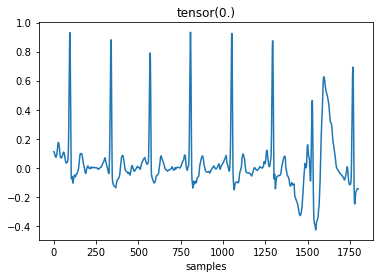

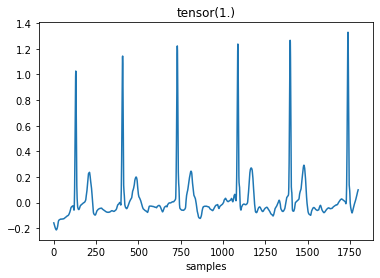

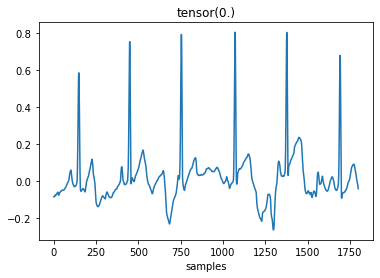

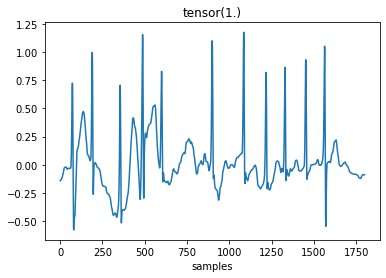

In [10]:
L = 1800
batch_size=4
i = 0
for X_tr, y_tr in data_iter(batch_size,dpath,Nlist,Alist,L):
    print(X_tr.shape)
    print(y_tr.shape)
    i=i+1
    for n in range(len(X_tr)):
        plt.plot(X_tr[n])
        plt.title(y_tr[n])
        plt.xlabel('samples')
        plt.show()
    break
    

### Hyperparameters, Model, Loss function, Optimization Algorithm 정의


In [11]:
L = 1800
batch_size=64
lr = 0.001
num_epochs = 50

- pytorch에서 미리 정의된 것들을 활용하여 편하게 model, loss function, optimization algorithm을 정의할 수 있습니다.

In [12]:
net = nn.Sequential(nn.Linear(L, 2))   
loss = nn.CrossEntropyLoss(reduction='mean')
alg = torch.optim.SGD(net.parameters(), lr)

### Training a Model
- 준비된 data loader, model, loss function, algorithm을 통해 학습을 진행하여 train set에 대한 loss값과 classification accuracy를 관찰합니다.

In [13]:
for epoch in range(num_epochs):
    l_train = []
    i = 0
    Ncorrect=0
    N=0
    for X_tr, y_tr in data_iter(batch_size,dpath,Nlist,Alist,L):
        y_tr_pred = net(X_tr)
        l = loss(y_tr_pred, y_tr.type(torch.LongTensor))
        l_train.append(l.sum().detach().numpy())
        l.backward()
        alg.step()
        alg.zero_grad()
        Ncorrect += torch.sum(y_tr==torch.argmax(y_tr_pred.softmax(1),dim=1)).numpy()
        N += len(X_tr)
        i=i+1
    if epoch%10==0:
        print(f'epoch #{epoch},train loss: {np.sum(l_train)/i}')
        print(f'accuracy of train set: {100*Ncorrect/(N)} %')

epoch #0,train loss: 0.69905196564107
accuracy of train set: 50.25712025316456 %.
epoch #10,train loss: 0.6641342066511323
accuracy of train set: 61.985759493670884 %.
epoch #20,train loss: 0.6468868014178698
accuracy of train set: 65.1503164556962 %.
epoch #30,train loss: 0.6378873511205746
accuracy of train set: 65.96123417721519 %.
epoch #40,train loss: 0.6318801203860512
accuracy of train set: 65.07120253164557 %.


- 미리 분리해 놓은 valid set에 대한 classification accuracy도 관찰해 봅시다. 
- 아마도 overfitting이 되었음을 확인할 수 있을 것 입니다.

In [17]:
for X_vd, y_vd in data_iter(Nvd,dpath,Nlist_vd,Alist_vd,L):
    y_vd_pred = net(X_vd)
    print('accuracy of valid set: ', 100*torch.sum(y_vd==torch.argmax(y_vd_pred.softmax(1),dim=1))/Nvd ,' %')

accuracy of valid set:  tensor(52.)  %.f2


- model의 출력은 softmax가 적용되지 않았음을 확인하여 봅니다.
    - pytorch에서 제공하는 crossentropyloss는 0,1,2,.. 로 되어 있는 label에 대해 알아서 처리를 해주기 때문에 label에 대해 one-hot encoding을 해주지 않아도 괜찮습니다.
- softmax를 적용하여 model의 출력을 probability와 같은 특성을 가지도록 변환해 봅니다.
- 각각의 출력이 의미하는 바를 이해해 봅시다.


In [15]:
n = 14
print(y_vd[n])
print(y_vd_pred[n])
print(y_vd_pred.softmax(1)[n])
print(torch.argmax(y_vd_pred.softmax(1)[n]))

tensor(0.)
tensor([ 0.1184, -0.2578], grad_fn=<SelectBackward0>)
tensor([0.5930, 0.4070], grad_fn=<SelectBackward0>)
tensor(0)
